# Text Classification
 


In [ ]:
!pip install -r requirements.txt

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.1 MB/s 
     |████████████████████████████████| 6.6 MB 44.4 MB/s 
     |████████████████████████████████| 596 kB 53.0 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [237]:
!unzip "/content/exercise3_data.zip" -d "/content/exercise3_data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/exercise3_data/exercise3_data/reuters/training/2237  
  inflating: /content/exercise3_data/exercise3_data/reuters/training/2238  
  inflating: /content/exercise3_data/exercise3_data/reuters/training/2239  
  inflating: /content/exercise3_data/exercise3_data/reuters/training/2240  
  inflating: /content/exercise3_data/exercise3_data/reuters/training/2244  
  inflating: /content/exercise3_data/exercise3_data/reuters/training/2246  
  inflating: /content/exercise3_data/exercise3_data/reuters/training/2247  
  inflating: /content/exercise3_data/exercise3_data/reuters/training/2249  
  inflating: /content/exercise3_data/exercise3_data/reuters/training/225  
  inflating: /content/exercise3_data/exercise3_data/reuters/training/2251  
  inflating: /content/exercise3_data/exercise3_data/reuters/training/2252  
  inflating: /content/exercise3_data/exercise3_data/reuters/training/2253  
  inflating: /content/exercise3_data/e

In [2]:
%matplotlib inline

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
import nltk
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import re
import time
import nltk as nlp
import math
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import tensorflow as tf 

In [4]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.metrics import classification_report, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN, LSTM, Bidirectional, GlobalAveragePooling1D, Dropout, Attention, TimeDistributed, GlobalMaxPooling1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
np.random.seed(24)

In [8]:
from transformers import DistilBertTokenizer, DistilBertConfig, TFDistilBertModel, BertTokenizer

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Physical devices cannot be modified after being initialized
Version:  2.8.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [10]:
def GetModelScores (estimator, X_train, X_test, y_train, y_test):
    start = time.time()
    scores_train = pd.DataFrame(columns= ['Accuracy','F1 Score','Precision','Recall','ROC_AUC'])
    scores_test = pd.DataFrame(columns= ['Accuracy','F1 Score','Precision','Recall','ROC_AUC'])
    
    model = estimator
    model.fit(X_train, y_train)
    
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    
    try:
        score_train = model.predict_proba(X_train)[:,1]
        roc_train= roc_auc_score(y_train, score_train, average = "weighted")
    except:
        roc_train = 0
        
    try:
        score_test = model.predict_proba(X_test)[:,1]
        roc_test= roc_auc_score(y_test, score_test, average = "weighted")
    except:
        roc_test = 0
    
    
    
    scores_train['Accuracy'] = accuracy_score(y_train, prediction_train)*100,
    scores_train['F1 Score'] = f1_score(y_train, prediction_train, average = "weighted")*100,
    scores_train['Precision'] = precision_score(y_train, prediction_train, average = "weighted")*100,
    scores_train['Recall'] = recall_score(y_train, prediction_train, average = "weighted")*100,
    scores_train['ROC_AUC'] = roc_train*100
    
       
    scores_test['Accuracy'] = accuracy_score(y_test, prediction_test)*100,
    scores_test['F1 Score'] = f1_score(y_test, prediction_test, average = "weighted")*100,
    scores_test['Precision'] = precision_score(y_test, prediction_test, average = "weighted")*100,
    scores_test['Recall'] = recall_score(y_test, prediction_test, average = "weighted")*100,
    scores_test['ROC_AUC'] = roc_test*100
    end = time.time()

    print(scores_train)
    print(scores_test)
    print("Inference time: ", end-start)

In [176]:
def GetOnlyScoresNN(estimator, X_train, X_test, y_train, y_test, multi=True):
    start =time.time()
    scores_train = pd.DataFrame(columns= ['Accuracy','F1 Score','Precision','Recall','ROC_AUC'])
    scores_test = pd.DataFrame(columns= ['Accuracy','F1 Score','Precision','Recall','ROC_AUC'])
    
    model = estimator

    prediction_tr = model.predict(X_train)
    prediction_ts = model.predict(X_test)
    
    if(multi):
      prediction_train = [np.argmax(x) for x in prediction_tr]
      prediction_test = [np.argmax(x) for x in prediction_ts]
    else:
      prediction_train = [round(x[0]) for x in prediction_tr]
      prediction_test = [round(x[0]) for x in prediction_ts]

    try:
        score_train = model.predict_proba(X_train)[:,1]
        roc_train= roc_auc_score(y_train, score_train, average = "weighted")
    except:
        roc_train = 0
        
    try:
        score_test = model.predict_proba(X_test)[:,1]
        roc_test= roc_auc_score(y_test, score_test, average = "weighted")
    except:
        roc_test = 0
    
    
    
    scores_train['Accuracy'] = accuracy_score(y_train, prediction_train)*100,
    scores_train['F1 Score'] = f1_score(y_train, prediction_train, average = "weighted")*100,
    scores_train['Precision'] = precision_score(y_train, prediction_train, average = "weighted")*100,
    scores_train['Recall'] = recall_score(y_train, prediction_train, average = "weighted")*100,
    scores_train['ROC_AUC'] = roc_train*100
    
       
    scores_test['Accuracy'] = accuracy_score(y_test, prediction_test)*100,
    scores_test['F1 Score'] = f1_score(y_test, prediction_test, average = "weighted")*100,
    scores_test['Precision'] = precision_score(y_test, prediction_test, average = "weighted")*100,
    scores_test['Recall'] = recall_score(y_test, prediction_test, average = "weighted")*100,
    scores_test['ROC_AUC'] = roc_test*100
    end = time.time()
    print(scores_train)
    print(scores_test)
    print("Inference time: ", end-start)

In [12]:
def GetOnlyScores (estimator, X_train, X_test, y_train, y_test):
    start =time.time()
    scores_train = pd.DataFrame(columns= ['Accuracy','F1 Score','Precision','Recall','ROC_AUC'])
    scores_test = pd.DataFrame(columns= ['Accuracy','F1 Score','Precision','Recall','ROC_AUC'])
    
    model = estimator

    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)

    try:
        score_train = model.predict_proba(X_train)[:,1]
        roc_train= roc_auc_score(y_train, score_train, average = "weighted")
    except:
        roc_train = 0
        
    try:
        score_test = model.predict_proba(X_test)[:,1]
        roc_test= roc_auc_score(y_test, score_test, average = "weighted")
    except:
        roc_test = 0
    
    
    
    scores_train['Accuracy'] = accuracy_score(y_train, prediction_train)*100,
    scores_train['F1 Score'] = f1_score(y_train, prediction_train, average = "weighted")*100,
    scores_train['Precision'] = precision_score(y_train, prediction_train, average = "weighted")*100,
    scores_train['Recall'] = recall_score(y_train, prediction_train, average = "weighted")*100,
    scores_train['ROC_AUC'] = roc_train*100
    
       
    scores_test['Accuracy'] = accuracy_score(y_test, prediction_test)*100,
    scores_test['F1 Score'] = f1_score(y_test, prediction_test, average = "weighted")*100,
    scores_test['Precision'] = precision_score(y_test, prediction_test, average = "weighted")*100,
    scores_test['Recall'] = recall_score(y_test, prediction_test, average = "weighted")*100,
    scores_test['ROC_AUC'] = roc_test*100
    end = time.time()
    print(scores_train)
    print(scores_test)
    print("Inference time: ", end-start)

# Constants

In [13]:
TRAIN_PCT = 0.8
VAL_PCT = 0.1
TEST_PCT = 0.008

VOCAB_SIZE = 8000
MAXLEN = 40
EMBEDDING_DIM = 32

# Import Data

### Data set 1 : Type of news dataset

Data Source - "https://www.kaggle.com/amananandrai/ag-news-classification-dataset?select=train.csv" 

The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

The class ids are numbered 1-4 where:

    1 represents World,

    2 represents Sports,

    3 represents Business,

    4 represents Sci/Tech.

In [238]:
train_news = pd.read_csv("./data/train.csv")
test_news = pd.read_csv("./data/test.csv")

In [239]:
train_news.head(10)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,3,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,3,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...
8,3,Safety Net (Forbes.com),Forbes.com - After earning a PH.D. in Sociolog...
9,3,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Stre..."


In [240]:
train_news.shape, test_news.shape

((120000, 3), (7600, 3))

In [241]:
train_news = train_news.rename(columns= {"Class Index": "labels", "Title": "title", "Description": "text"})

In [242]:
test_news = test_news.rename(columns= {"Class Index": "labels", "Title": "title", "Description": "text"})

In [ ]:
# Data = []
# import os
# for dirname, _, filenames in os.walk('/content/archive'):
#     for filename in filenames:
#         #print(os.path.join(dirname, filename))
#         doc_class = filename.split('_')[0].lower()
#         doc_titles = filename
#         documents = preprocess(os.path.join(dirname, filename))
        
#         Data.append([doc_titles, documents, doc_class])

# df = pd.DataFrame (Data, columns = ['Title', 'Document', 'Class'])
# df

### Data set 2

In [243]:
stop_words = stopwords.words('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

In [115]:
df = pd.read_csv("./data/santiment_reduced.csv")

In [116]:
df

,0,1,2,3,4,5
0,0,2204444171,Wed Jun 17 02:14:00 PDT 2009,NO_QUERY,einmensch,wants to compete! i want hard competition! i w...
1,0,2017152437,Wed Jun 03 07:56:34 PDT 2009,NO_QUERY,keithmorrison,It seems we are stuck on the ground in Amarill...
2,0,1967043408,Fri May 29 18:52:13 PDT 2009,NO_QUERY,PunkieDory,where the f are my pinking shears? rarararrrar...
3,0,2208721054,Wed Jun 17 09:32:48 PDT 2009,NO_QUERY,DYkEY_tYPE,0ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER...
4,4,2018731586,Wed Jun 03 10:25:27 PDT 2009,NO_QUERY,BlueSmartiies,@ reply me pls
...,...,...,...,...,...,...
119995,0,2199928253,Tue Jun 16 18:12:00 PDT 2009,NO_QUERY,desigirl14,OMG!! I wish I could go to Dubai and see the P...
119996,4,2016420020,Wed Jun 03 06:44:48 PDT 2009,NO_QUERY,missvmarie,good morning to all!
119997,0,1981037142,Sun May 31 08:16:12 PDT 2009,NO_QUERY,chaz_6,#Pidgin 2.5.6 + #GnuTLS 2.8.0 = #gtalk woes (T...
119998,0,2049007692,Fri Jun 05 16:08:21 PDT 2009,NO_QUERY,ihearttx3,i am kind of mad right now cause outside is li...


In [117]:
df.columns = ['labels', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df

,labels,text
0,0,wants to compete! i want hard competition! i w...
1,0,It seems we are stuck on the ground in Amarill...
2,0,where the f are my pinking shears? rarararrrar...
3,0,0ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER...
4,4,@ reply me pls
...,...,...
119995,0,OMG!! I wish I could go to Dubai and see the P...
119996,4,good morning to all!
119997,0,#Pidgin 2.5.6 + #GnuTLS 2.8.0 = #gtalk woes (T...
119998,0,i am kind of mad right now cause outside is li...


In [118]:
# take only a quarter
#df = df.sample(n=120000, random_state=0)
df.text = df.text.apply(lambda x: preprocess(x))
df

,labels,text
0,0,wants compete want hard competition want rally...
1,0,seems stuck ground amarillo put ground stop fl...
2,0,f pinking shears rarararrrarararr babyproofing...
3,0,0ff t0 meetin hate ppl v0lunteer free time grrr
4,4,reply pls
...,...,...
119995,0,omg wish could go dubai see palm jumeriah ahh ...
119996,4,good morning
119997,0,pidgin 2 5 6 gnutls 2 8 0 gtalk woes tls packe...
119998,0,kind mad right cause outside like rainy cloudy...


# Train Test Val split

In [20]:
def train_test_val_split(data) :

    train_data = pd.DataFrame()
    val_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for (label, group_texts) in data.groupby('labels'):

        group_texts = group_texts.sample(len(group_texts))  ## shuffle the data for each group

        train_data_end_index = int(len(group_texts) * TRAIN_PCT)
        val_data_end_index = train_data_end_index + int(len(group_texts) * VAL_PCT)


        train_data_in_group = group_texts[:train_data_end_index]
        val_data_in_group = group_texts[train_data_end_index:val_data_end_index]
        test_data_in_group = group_texts[val_data_end_index :]

        print(len(train_data_in_group), len(val_data_in_group), len(test_data_in_group))

        train_data = train_data.append(train_data_in_group)
        val_data = val_data.append(val_data_in_group)
        test_data = test_data.append(test_data_in_group)
        
    return train_data, val_data, test_data

### Data set 1

In [244]:
train_data1, val_data1, test_data1 = train_test_val_split(train_news)
test_data1 = test_data1.append(test_news)

24000 3000 3000
24000 3000 3000
24000 3000 3000
24000 3000 3000


Now we have created validation data and added more data in the test data as well

In [245]:
print("Train data shape:", train_data1.shape)
print("Test data shape:", test_data1.shape)
print("Validiation data shape:", val_data1.shape)

Train data shape: (96000, 3)
Test data shape: (19600, 3)
Validiation data shape: (12000, 3)


### Data set 2

In [119]:
df.labels = df.labels.replace(4, 1)

In [120]:
train_data2, val_data2, test_data2 = train_test_val_split(df)

47929 5991 5992
48070 6008 6010


In [121]:
print("Train data shape:", train_data2.shape)
print("Test data shape:", test_data2.shape)
print("Validiation data shape:", val_data2.shape)

Train data shape: (95999, 2)
Test data shape: (12002, 2)
Validiation data shape: (11999, 2)


# Data Analysis

In [246]:
def plot_distribution(train, test, val) :
    fig, axes =plt.subplots(3,1,figsize=(8,18))

    fig.suptitle('Count of each label in data')

    sns.countplot(ax=axes[0], x = train.labels)
    axes[0].set_title('Train data')

    sns.countplot(ax=axes[1], x = val.labels)
    axes[1].set_title('Validation data')

    sns.countplot(ax=axes[2], x = test.labels)
    axes[2].set_title("Test data")

### Data set 1

In [247]:
train_news.labels.value_counts(), test_news.labels.value_counts()

(3    30000
 4    30000
 2    30000
 1    30000
 Name: labels, dtype: int64, 3    1900
 4    1900
 2    1900
 1    1900
 Name: labels, dtype: int64)

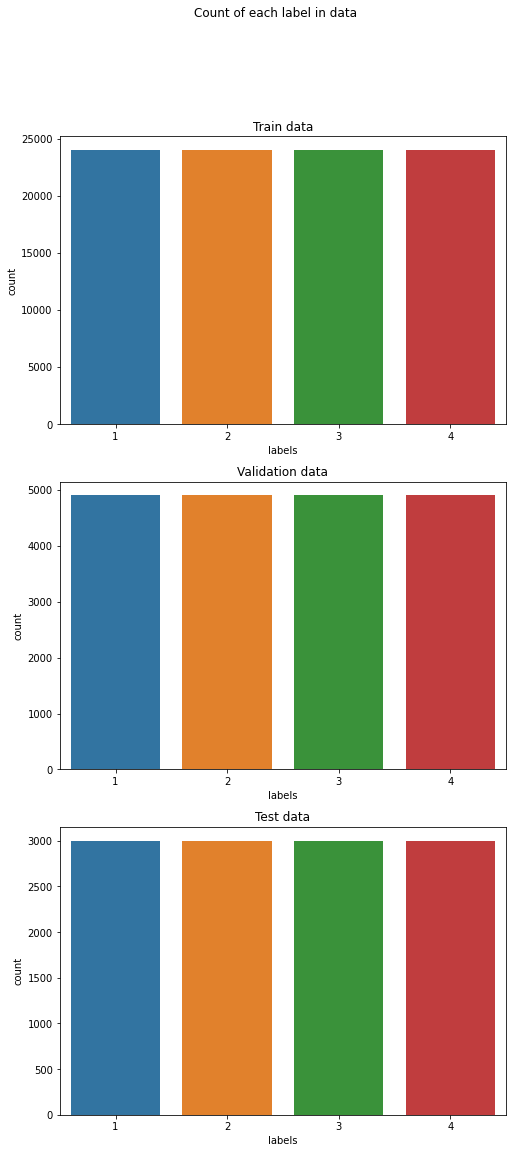

In [ ]:
plot_distribution(train_data1, val_data1, test_data1)

We have prefectly balanced datasets so there is no need for under-/oversampling.

We split the train data into train and validation datasets so we can inspect both of them

In [248]:
train_data1.labels = train_data1['labels'].apply(lambda x: x-1)
val_data1.labels = val_data1['labels'].apply(lambda x: x-1)
test_data1.labels = test_data1['labels'].apply(lambda x: x-1)

In [249]:
labels_dict1 = {
    "World": 0,
    "Sport": 1,
    "Business": 2,
    "Tech": 3
}

The class ids now are numbered 0-3 where:

    0 represents World,

    1 represents Sports,

    2 represents Business,

    3 represents Sci/Tech.

### Data set 2

In [ ]:
df.labels.value_counts()

4    60088
0    59912
Name: labels, dtype: int64

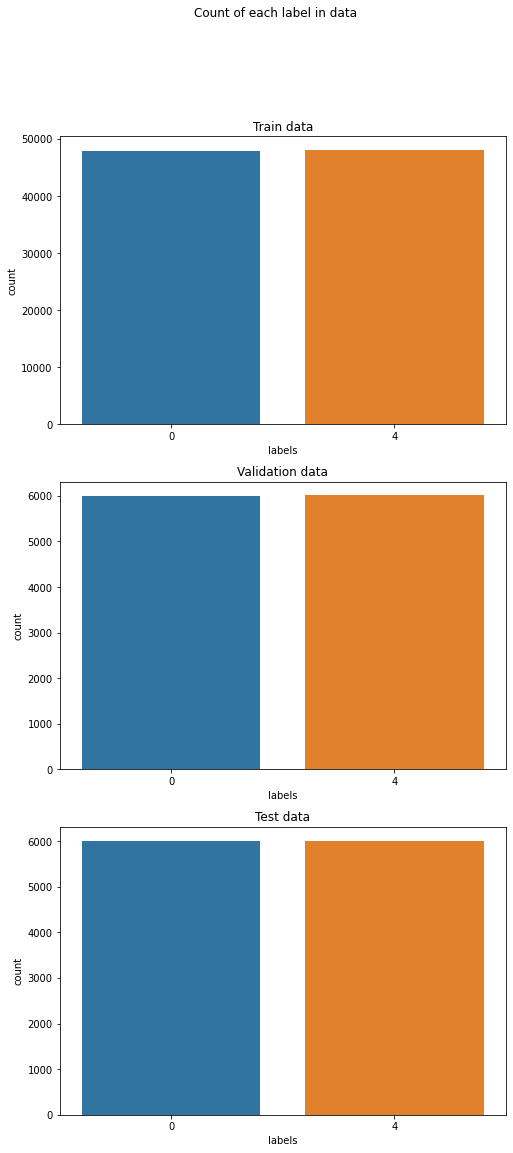

In [ ]:
plot_distribution(train_data2, val_data2, test_data2)

We have a well balanced data set

In [146]:
train_data2.labels = train_data2.labels.replace(4, 1)
val_data2.labels = val_data2.labels.replace(4, 1)
test_data2.labels = test_data2.labels.replace(4, 1)

In [147]:
labels_dict2 = {
    "Not Satisfied": 0,
    "Satisfied": 1,
}

## Length of each sentance

In [ ]:
def plot_lenght_sentances(train, val, test) :
    fig, axes = plt.subplots(3,1,figsize=(8,16))

    fig.suptitle('Count of each label in data')

    sns.distplot(ax=axes[0], x = [len(re.findall('[a-z-]+', text, flags=re.I)) for text in train.text], 
                 kde=False, rug=False)
    axes[0].set_title("Train data")
    
    sns.distplot(ax=axes[1], x = [len(re.findall('[a-z-]+', text, flags=re.I)) for text in val.text], 
                 kde=False, rug=False)
    axes[1].set_title("Validation data")
    
    sns.distplot(ax=axes[2], x = [len(re.findall('[a-z-]+', text, flags=re.I)) for text in test.text], 
                 kde=False, rug=False)
    axes[2].set_title("Test data")

### Data set 1

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


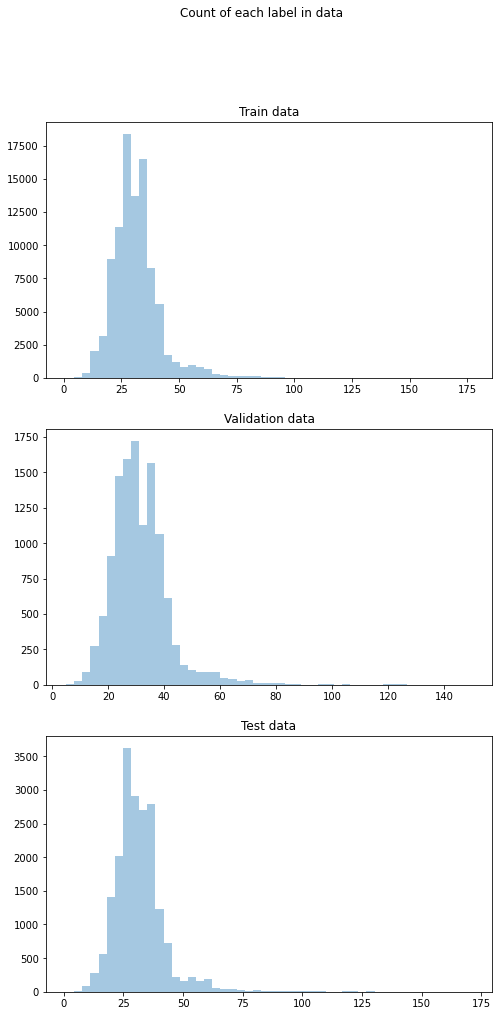

In [ ]:
plot_lenght_sentances(train_data1, val_data1, test_data1)

Here we can see that the majority of each document contains within 20 - 40 tokens. That is good because we dont have really long seqences of words.

This is only by the text column. I didn't include the title in this. 

### Data set 2

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


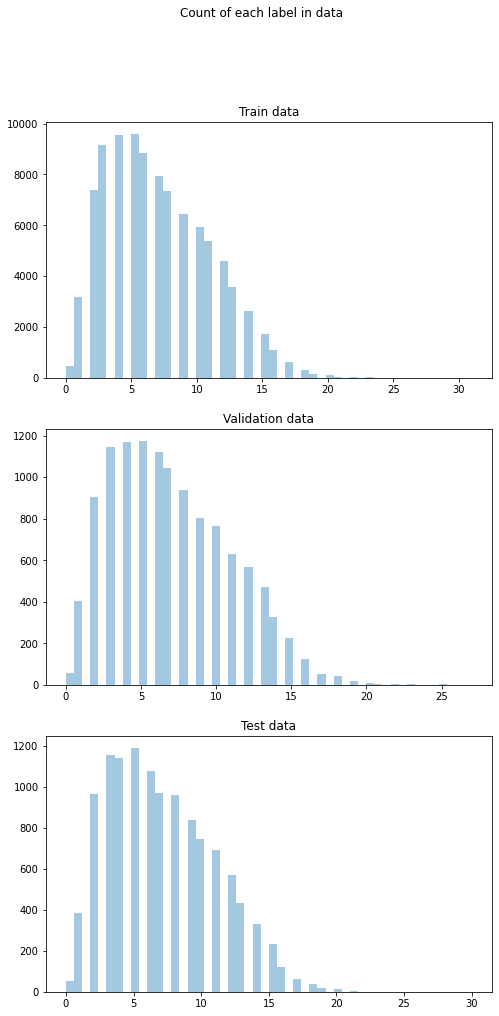

In [ ]:
plot_lenght_sentances(train_data2, val_data2, test_data2)

For data set 2 we can see that the majority of each document contains within 0 and 20 tokens.

# Text Preprocessing 

## CountVectorizer Tokenization

In [23]:
def keras_tokenize(train, val, test) :
    tokenizer = Tokenizer(num_words=8000, lower=True)
    tokenizer.fit_on_texts(train.text.values)

    # Create and Fit tokenizer
    X_train = tokenizer.texts_to_sequences(train.text.values)
    X_val = tokenizer.texts_to_sequences(val.text.values)
    X_test = tokenizer.texts_to_sequences(test.text.values)
    
    return X_train, X_val, X_test

In [48]:
def pad_tokenize(X_train, X_val, X_test, maxlen=MAXLEN) :
    # Pad data
    X_train_padded = pad_sequences(X_train, padding="post", truncating="post", maxlen=maxlen)
    X_val_padded = pad_sequences(X_val, padding="post", truncating="post", maxlen=maxlen)
    X_test_padded = pad_sequences(X_test, padding="post", truncating="post", maxlen=maxlen)
    
    return X_train_padded, X_val_padded, X_test_padded

In [25]:
def count_tokenize(train, val, test) :
    vect = CountVectorizer(max_features=8000, stop_words="english")

    train_bow = vect.fit_transform(train.text.values)
    val_bow = vect.transform(val.text.values)
    test_bow = vect.transform(test.text.values)
    
    return train_bow, val_bow, test_bow

### Data set 1

In [250]:
X_train1, X_val1, X_test1 = keras_tokenize(train_data1, val_data1, test_data1)

In [251]:
X_train_padded1, X_val_padded1, X_test_padded1 = pad_tokenize(X_train1, X_val1, X_test1)

In [252]:
X_train_padded1[0]

array([  39,   48,    4,  705, 3025,  738,  808, 1067,    1,   81,  343,
          7,   51,    3,  351,  235,   12, 1051, 1610,    7,  939,    6,
        574,   19,   82, 2023,  809,    5,  689,  143, 2302,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [253]:
train_bow1, val_bow1, test_bow1 = count_tokenize(train_data1, val_data1, test_data1)

In [254]:
train_bow1

<96000x8000 sparse matrix of type '<class 'numpy.int64'>'
	with 1586960 stored elements in Compressed Sparse Row format>

### Data set 2

In [123]:
X_train2, X_val2, X_test2 = keras_tokenize(train_data2, val_data2, test_data2)

In [124]:
X_train_padded2, X_val_padded2, X_test_padded2 = pad_tokenize(X_train2, X_val2, X_test2, maxlen=10)

In [125]:
len(X_train_padded2[0])

10

In [128]:
train_bow2, val_bow2, test_bow2 = count_tokenize(train_data2, val_data2, test_data2)

In [129]:
train_bow2

<95999x8000 sparse matrix of type '<class 'numpy.int64'>'
	with 510746 stored elements in Compressed Sparse Row format>

In [130]:
train_data2

,labels,text
114538,0,tried install twitter application phone work t...
81641,0,tomorrow father day spend daddy miss hope spen...
5447,0,ready retire mommy liking bell jar sad
43654,0,bye bye magics sorry dwight 2 0
67551,0,well went back hopkins people morans ah
...,...,...
116717,1,heading vegas let go wings
34080,1,creiamo il trend twitterzioni
117349,1,came back home bugis lt 3 new eyeliner
47127,1,back fun day devil hole days like glad live falls


# Building Model

So for text modeling I have to use Recurrent Neural Networks. They allow previous outputs to be used as inputs while having hidden states. We can keep track of the words being used for each timestep. Model size does not increase with the size of the input but there is a problem with longer sentances called vanishing/exploding gradients. Also they have difficulty accessing information from long time ago.

First I am going to inspect how our sample data is performing with basic RNN and then I will try Encoder part of Transformer with BiDirectional LSTM layer.

# 1) Basic ML models

LogisticRegression, DecisionTreeClassifier and RandomForestClassifier

### Data set 1

In [255]:
GetModelScores(LogisticRegression(), train_bow1, val_bow1, train_data1.labels, val_data1.labels)

    Accuracy   F1 Score  Precision     Recall  ROC_AUC
0  94.292708  94.287329  94.296121  94.292708        0
    Accuracy   F1 Score  Precision     Recall  ROC_AUC
0  89.058333  89.054058  89.055937  89.058333        0
Inference time:  8.733370780944824


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
GetModelScores(DecisionTreeClassifier(), train_bow1, val_bow1, train_data1.labels, val_data1.labels)

    Accuracy   F1 Score  Precision     Recall  ROC_AUC
0  99.889583  99.889571  99.889704  99.889583        0
   Accuracy  F1 Score  Precision  Recall  ROC_AUC
0    81.575  81.50974  81.481202  81.575        0
Inference time:  36.403520822525024


In [ ]:
GetModelScores(RandomForestClassifier(), train_bow1, val_bow1, train_data1.labels, val_data1.labels)

   Accuracy   F1 Score  Precision   Recall  ROC_AUC
0   99.8875  99.887503  99.887526  99.8875        0
   Accuracy   F1 Score  Precision  Recall  ROC_AUC
0     87.55  87.478233  87.499573   87.55        0
Inference time:  232.00382804870605


### Data set 2

In [132]:
GetModelScores(LogisticRegression(), train_bow2, val_bow2, train_data2.labels, val_data2.labels)

    Accuracy  F1 Score  Precision     Recall   ROC_AUC
0  79.090407  79.07216  79.185501  79.090407  87.19073
    Accuracy   F1 Score  Precision     Recall    ROC_AUC
0  74.739562  74.719809   74.81133  74.739562  82.502893
Inference time:  1.4092049598693848


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [133]:
GetModelScores(DecisionTreeClassifier(), train_bow2, val_bow2, train_data2.labels, val_data2.labels)

    Accuracy   F1 Score  Precision     Recall    ROC_AUC
0  98.129147  98.129094  98.133315  98.129147  99.915942
   Accuracy   F1 Score  Precision    Recall    ROC_AUC
0  69.35578  69.355772  69.356111  69.35578  70.249265
Inference time:  32.94676733016968


In [57]:
GetModelScores(RandomForestClassifier(), train_bow2, val_bow2, train_data2.labels, val_data2.labels)

    Accuracy   F1 Score  Precision     Recall    ROC_AUC
0  98.146856  98.146732  98.157561  98.146856  99.684764
    Accuracy   F1 Score  Precision     Recall    ROC_AUC
0  72.681057  72.669907  72.714105  72.681057  80.213736
Inference time:  268.66420793533325


## Optimisation

In both case (data set 1 and 2) the Logistic Regression performs best so we will tune its parameters with a GridSearchCV

In [256]:
parameters = {
    "C": [0.1, 0.01, 1, 0.001]
}

In [257]:
def search(train_bow, train_data) :
    start = time.time()

    grid = GridSearchCV(LogisticRegression(), parameters, scoring = 'accuracy', cv = 5, n_jobs =-1)
    grid.fit(train_bow, train_data.labels)

    end = time.time()
    print("Inference time: ", end-start)
    
    return grid

### Data set 1

In [258]:
grid1 = search(train_bow1, train_data1)

Inference time:  59.31731462478638


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [259]:
grid1.best_estimator_

LogisticRegression(C=0.1)

In [260]:
GetOnlyScores(grid1, train_bow1, val_bow1, train_data1.labels, val_data1.labels)

    Accuracy   F1 Score  Precision     Recall  ROC_AUC
0  92.401042  92.387772  92.395278  92.401042        0
   Accuracy   F1 Score  Precision  Recall  ROC_AUC
0     90.15  90.136417   90.14066   90.15        0
Inference time:  0.16771554946899414


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 720x576 with 0 Axes>

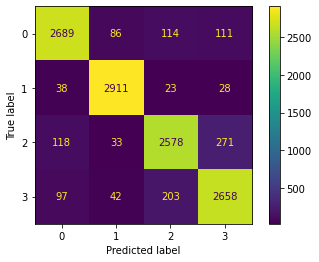

In [ ]:
plt.figure(figsize=(10,8))
plot_confusion_matrix(grid1, val_bow1, val_data1.labels)

### Data set 2

In [60]:
grid2 = search(train_bow2, train_data2)

Inference time:  10.209161043167114


In [61]:
grid2.best_estimator_

LogisticRegression(C=0.1)

In [62]:
GetOnlyScores(grid2, train_bow2, val_bow2, train_data2.labels, val_data2.labels)

    Accuracy   F1 Score  Precision     Recall    ROC_AUC
0  77.559141  77.530039  77.694578  77.559141  85.206639
    Accuracy   F1 Score  Precision     Recall    ROC_AUC
0  75.122927  75.076217  75.303535  75.122927  82.402679
Inference time:  0.1669445037841797


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 720x576 with 0 Axes>

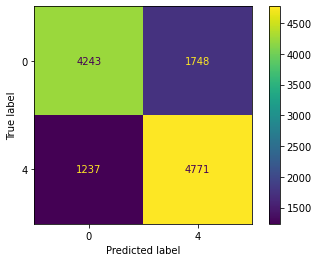

In [63]:
plt.figure(figsize=(10,8))
plot_confusion_matrix(grid2, val_bow2, val_data2.labels)

# 2) Neural Networks

In [180]:
def confusion_matrix_NN(model, val_data, X_val_padded, labels_dict, multi=True):
    if(multi):
      cf = confusion_matrix(val_data.labels, [np.argmax(x) for x in model.predict(X_val_padded)])
    else:
      cf = confusion_matrix(val_data.labels, [round(x[0]) for x in model.predict(X_val_padded)])
    ConfusionMatrixDisplay(confusion_matrix=cf).plot()
    plt.xticks(range(len(labels_dict.keys())),labels_dict, fontsize=12)
    plt.yticks(rotation = 45)
    plt.yticks(range(len(labels_dict.keys())), labels_dict, fontsize=12)
    plt.show()

## RNN

In [ ]:
tf.keras.backend.clear_session()

In [74]:
rnn = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, input_length = MAXLEN),
    SimpleRNN(32, return_sequences = True),
    Dropout(0.2),
    SimpleRNN(64, return_sequences = True),
    Dropout(0.1),
    SimpleRNN(64, return_sequences = True),
    Dropout(0.1),
    SimpleRNN(12),
    Dropout(0.1),
    Dense(4, activation='softmax')
])


### Data set 1

In [75]:
rnn.compile(optimizer = RMSprop(learning_rate=(0.001)), 
             loss = SparseCategoricalCrossentropy(), 
             metrics = ['accuracy'])

In [ ]:
rnn_history1 = rnn.fit(x = X_train_padded1, y = train_data1.labels.values, epochs = 10,
                callbacks = [TensorBoard(log_dir = "logs_rnn_basic"), 
                             EarlyStopping(patience = 2, restore_best_weights=True)],
                validation_data=(X_val_padded1, val_data1.labels.values), batch_size = 1024)

Epoch 1/10
94/94 [==============================] - 22s 160ms/step - loss: 1.0379 - accuracy: 0.5464 - val_loss: 0.7349 - val_accuracy: 0.7308
Epoch 2/10
94/94 [==============================] - 14s 150ms/step - loss: 0.6252 - accuracy: 0.7911 - val_loss: 0.5787 - val_accuracy: 0.8008
Epoch 3/10
94/94 [==============================] - 14s 150ms/step - loss: 0.5003 - accuracy: 0.8396 - val_loss: 0.5780 - val_accuracy: 0.7953
Epoch 4/10
94/94 [==============================] - 14s 150ms/step - loss: 0.4086 - accuracy: 0.8717 - val_loss: 0.4210 - val_accuracy: 0.8633
Epoch 5/10
94/94 [==============================] - 14s 146ms/step - loss: 0.3560 - accuracy: 0.8894 - val_loss: 0.3698 - val_accuracy: 0.8800
Epoch 6/10
94/94 [==============================] - 14s 147ms/step - loss: 0.3238 - accuracy: 0.8982 - val_loss: 0.3723 - val_accuracy: 0.8779
Epoch 7/10
94/94 [==============================] - 14s 149ms/step - loss: 0.2983 - accuracy: 0.9063 - val_loss: 0.3598 - val_accuracy: 0.8848

In [ ]:
GetOnlyScoresNN(rnn, X_train_padded1, X_val_padded1, train_data1.labels, val_data1.labels)

    Accuracy   F1 Score  Precision     Recall  ROC_AUC
0  93.246875  93.251709   93.26188  93.246875        0
   Accuracy   F1 Score  Precision  Recall  ROC_AUC
0    88.475  88.490845  88.511452  88.475        0
Inference time:  41.709821939468384


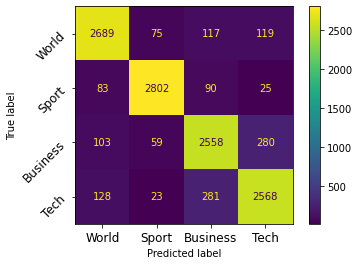

In [ ]:
confusion_matrix_NN(rnn, val_data1, X_val_padded1, labels_dict1)

### Data set 2

In [134]:
rnn2 = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, input_length = 10),
    SimpleRNN(32, return_sequences = True),
    Dropout(0.2),
    SimpleRNN(64, return_sequences = True),
    Dropout(0.1),
    SimpleRNN(64, return_sequences = True),
    Dropout(0.1),
    SimpleRNN(12),
    Dense(64),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

In [135]:
rnn2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 10, 32)            256000    
                                                                 
 simple_rnn_28 (SimpleRNN)   (None, 10, 32)            2080      
                                                                 
 dropout_28 (Dropout)        (None, 10, 32)            0         
                                                                 
 simple_rnn_29 (SimpleRNN)   (None, 10, 64)            6208      
                                                                 
 dropout_29 (Dropout)        (None, 10, 64)            0         
                                                                 
 simple_rnn_30 (SimpleRNN)   (None, 10, 64)            8256      
                                                                 
 dropout_30 (Dropout)        (None, 10, 64)           

In [149]:
train_data2.labels.value_counts()

1    48070
0    47929
Name: labels, dtype: int64

In [150]:
rnn2.compile(optimizer = "adam",
             loss = "binary_crossentropy",
             metrics = ['accuracy'])

In [151]:
X_train_padded2.shape, train_data2.labels.values.shape

((95999, 10), (95999,))

In [152]:
X_val_padded2.shape, val_data2.labels.values.shape

((11999, 10), (11999,))

In [153]:
rnn_history2 = rnn2.fit(X_train_padded2, train_data2.labels.values, epochs = 10,
                callbacks = [EarlyStopping(patience = 2, restore_best_weights=True)],
                validation_data=(X_val_padded2, val_data2.labels.values), batch_size = 1024)

Epoch 1/10
94/94 [==============================] - 7s 48ms/step - loss: 0.4662 - accuracy: 0.7796 - val_loss: 0.5049 - val_accuracy: 0.7546
Epoch 2/10
94/94 [==============================] - 4s 44ms/step - loss: 0.4319 - accuracy: 0.8006 - val_loss: 0.5250 - val_accuracy: 0.7478
Epoch 3/10
94/94 [==============================] - 4s 45ms/step - loss: 0.3990 - accuracy: 0.8190 - val_loss: 0.5549 - val_accuracy: 0.7406


In [178]:
GetOnlyScoresNN(rnn2, X_train_padded2, X_val_padded2, train_data2.labels, val_data2.labels, multi=False)

    Accuracy   F1 Score  Precision     Recall  ROC_AUC
0  81.242513  81.242523  81.242648  81.242513        0
    Accuracy   F1 Score  Precision     Recall  ROC_AUC
0  75.464622  75.464612  75.465021  75.464622        0
Inference time:  22.5715651512146


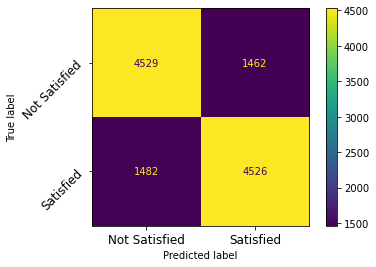

In [181]:

confusion_matrix_NN(rnn2, val_data2, X_val_padded2, labels_dict2, multi=False)

## Bi-Directional LSTM

In [204]:
def create_lstm(nb_outputs, activation="softmax", input_length=MAXLEN) :
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=input_length))
    model.add(Bidirectional(LSTM(128, return_sequences=True))) 
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.25))
    model.add(Dense(128))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.25))
    model.add(Dense(nb_outputs, activation=activation))
    #model.summary()
    
    return model

### Data set 1

In [183]:
lstm1 = create_lstm(4)

In [ ]:
lstm1.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer=RMSprop(learning_rate=(0.001)), 
              metrics=['accuracy']) 

In [ ]:
lstm1.fit(x = X_train_padded1, y = train_data1.labels.values, epochs = 10,
          callbacks =  [EarlyStopping(patience = 2, restore_best_weights=True)],
          validation_data=(X_val_padded1, val_data1.labels.values), batch_size = 1024)

Epoch 1/10
94/94 [==============================] - 14s 71ms/step - loss: 0.7096 - accuracy: 0.7247 - val_loss: 0.3905 - val_accuracy: 0.8668
Epoch 2/10
94/94 [==============================] - 5s 55ms/step - loss: 0.3570 - accuracy: 0.8811 - val_loss: 0.3534 - val_accuracy: 0.8832
Epoch 3/10
94/94 [==============================] - 5s 56ms/step - loss: 0.3036 - accuracy: 0.8989 - val_loss: 0.2972 - val_accuracy: 0.8992
Epoch 4/10
94/94 [==============================] - 5s 56ms/step - loss: 0.2708 - accuracy: 0.9101 - val_loss: 0.3027 - val_accuracy: 0.8969
Epoch 5/10
94/94 [==============================] - 5s 57ms/step - loss: 0.2495 - accuracy: 0.9163 - val_loss: 0.3090 - val_accuracy: 0.9003


In [ ]:
GetOnlyScoresNN(lstm1, X_train_padded1, X_val_padded1, train_data1.labels, val_data1.labels)

   Accuracy   F1 Score  Precision    Recall  ROC_AUC
0  92.15625  92.169959   92.27405  92.15625        0
    Accuracy   F1 Score  Precision     Recall  ROC_AUC
0  89.916667  89.953725  90.082647  89.916667        0
Inference time:  16.418006896972656


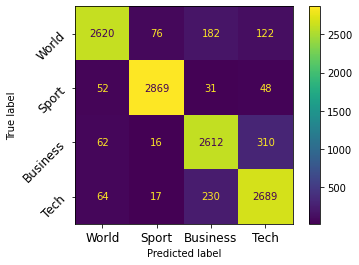

In [ ]:
confusion_matrix_NN(lstm1, val_data1, X_val_padded1, labels_dict1)

### Data set 2

In [205]:
lstm2 = create_lstm(1, activation="sigmoid", input_length=10)

In [206]:
lstm2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 10, 32)            256000    
                                                                 
 bidirectional_10 (Bidirecti  (None, 10, 256)          164864    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 10, 128)          164352    
 onal)                                                           
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_30 (Dense)            (None, 256)               33024     
                                                     

In [207]:
lstm2.compile(loss='binary_crossentropy',
              optimizer="adam", 
              metrics=['accuracy']) 

In [208]:
lstm2.fit(x = X_train_padded2, y = train_data2.labels.values, epochs = 10,
          callbacks =  [EarlyStopping(patience = 2, restore_best_weights=True)],
          validation_data=(X_val_padded2, val_data2.labels.values), batch_size = 1024)

Epoch 1/10
94/94 [==============================] - 8s 32ms/step - loss: 0.5680 - accuracy: 0.6910 - val_loss: 0.4989 - val_accuracy: 0.7539
Epoch 2/10
94/94 [==============================] - 2s 17ms/step - loss: 0.4779 - accuracy: 0.7710 - val_loss: 0.4973 - val_accuracy: 0.7535
Epoch 3/10
94/94 [==============================] - 2s 17ms/step - loss: 0.4543 - accuracy: 0.7857 - val_loss: 0.5128 - val_accuracy: 0.7517
Epoch 4/10
94/94 [==============================] - 2s 17ms/step - loss: 0.4329 - accuracy: 0.7970 - val_loss: 0.5137 - val_accuracy: 0.7466


In [209]:
GetOnlyScoresNN(lstm2, X_train_padded2, X_val_padded2, train_data2.labels, val_data2.labels, multi=False)

    Accuracy   F1 Score  Precision     Recall  ROC_AUC
0  79.458119  79.432655  79.596641  79.458119        0
    Accuracy   F1 Score  Precision     Recall  ROC_AUC
0  75.347946  75.317932  75.464507  75.347946        0
Inference time:  18.79486060142517


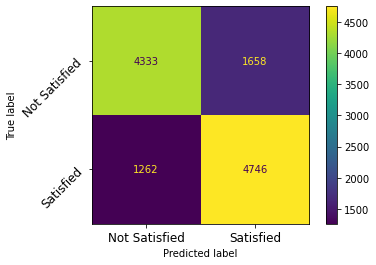

In [ ]:
confusion_matrix_NN(lstm2, val_data2, X_val_padded2, labels_dict2)

# 3) DistilBert 

In [225]:
def plot_loss_curve(bert_history) :
    plt.figure(figsize=(8,6))
    plt.title("Losses")
    plt.plot(bert_history.history['loss'])
    plt.plot(bert_history.history['val_loss'])
    plt.show()

In [226]:
def plot_accuracy_curve(bert_history) :
    plt.figure(figsize=(8,6))
    plt.title("Accuracy")
    plt.plot(bert_history.history['accuracy'])
    plt.plot(bert_history.history['val_accuracy'])
    plt.show()

## A) Tokenization

Here i will use pre-trained tokenizer who returns 3 types of tokenizer output

In [210]:
distil_bert = 'distilbert-base-uncased'

In [211]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAXLEN, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [212]:
def tokenize_in_mask(data, tokenizer) :
    X_bert = tokenize(data.text, tokenizer) 
    
    input_ids = X_bert[0]
    attention_mask = X_bert[1]
    
    return input_ids, attention_mask

### Data set 1

In [213]:
tokenizer1 = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=MAXLEN, pad_to_max_length=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
train_input_ids1, train_attention_mask1 = tokenize_in_mask(train_data1, tokenizer1) 
test_input_ids1, test_attention_mask1 = tokenize_in_mask(test_data1, tokenizer1) 
val_input_ids1, val_attention_mask1 = tokenize_in_mask(val_data1, tokenizer1) 

  0%|          | 0/96000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 12000/12000 [00:12<00:00, 995.87it/s]


### Data set 2

In [214]:
tokenizer2 = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=MAXLEN, pad_to_max_length=True)

In [215]:
train_input_ids2, train_attention_mask2 = tokenize_in_mask(train_data2, tokenizer2) 
test_input_ids2, test_attention_mask2 = tokenize_in_mask(test_data2, tokenizer2) 
val_input_ids2, val_attention_mask2 = tokenize_in_mask(val_data2, tokenizer2) 

  0%|          | 0/95999 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 11999/11999 [00:04<00:00, 2933.64it/s]


After Bert tokenzization we have output data with 3 categories.

    1) The input ids — for classification problem, two inputs sentences should be tokenized and concatenated together. We see a lot of [101] and in the end [102]. Those are special BERT tokens for [CLS] and [SEP]

    2) The input masks — allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input ids, and contains 1 anywhere the the input ids is not padding.

    3) The input types — also has the same shape as the input ids, but inside the non-padded region, it contains 0 or 1 indicating which sentence the token is a part of.
    
We are going to use only first two because we don't need 3rd for DistilBert

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.
BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

DistilBert is smaller, faser, cheaper version of Bert. It has 40% less parameters and runs 60% faster while preserving over 95% of BERT's performances.

I this project I will be using this version.

## B) Build DistilBert

In [217]:
def create_bert(nb_outputs, activation="softmax"):    
    config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
    config.output_hidden_states = False
    transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config=config)

    input_ids_in = tf.keras.layers.Input(shape=(MAXLEN,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(MAXLEN,), name='masked_token', dtype='int32') 

    embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding_layer)
    X = tf.keras.layers.GlobalMaxPool1D()(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Dense(nb_outputs, activation=activation)(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

    for layer in model.layers[:3]:
        layer.trainable = False

    return model

This model as we see has 2 inputs from tokenized text: (input_tokens, masked_tokens)
Bert Embedding layer has 2 oputputs: 

      1)pooled_output to represent each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.

      2)sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.
      
We are taking only the second output.

For training parameters we will use only after Bert layer ones because of computation power :/.
We make some regularization with Dropout and Global Max Pooling and final 4 nodes Dense layer for the classification

### Data set 1

In [ ]:
bert1 = create_bert(4)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
bert1.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.01), 
              metrics=['accuracy'])

In [ ]:
bert_history1 = bert1.fit([train_input_ids1, train_attention_mask1], 
                                train_data1.labels.values, batch_size=1024,
                                validation_data=([val_input_ids1, val_attention_mask1], val_data1.labels.values),
                                epochs=15,
                                callbacks=[
                                    EarlyStopping(
                                        monitor='val_accuracy',
                                        patience=3,
                                        restore_best_weights=True),
                                    ModelCheckpoint(
                                        filepath='bert_weights.h5',
                                        monitor='val_loss', 
                                        mode='min', 
                                        save_best_only=True,
                                        save_weights_only=True)
                                   ])

Epoch 1/15
94/94 [==============================] - 160s 2s/step - loss: 0.3766 - accuracy: 0.8643 - val_loss: 0.2764 - val_accuracy: 0.9018
Epoch 2/15
94/94 [==============================] - 148s 2s/step - loss: 0.2665 - accuracy: 0.9058 - val_loss: 0.2368 - val_accuracy: 0.9124
Epoch 3/15
94/94 [==============================] - 148s 2s/step - loss: 0.2407 - accuracy: 0.9138 - val_loss: 0.2347 - val_accuracy: 0.9162
Epoch 4/15
94/94 [==============================] - 148s 2s/step - loss: 0.2252 - accuracy: 0.9196 - val_loss: 0.2160 - val_accuracy: 0.9214
Epoch 5/15
94/94 [==============================] - 147s 2s/step - loss: 0.2112 - accuracy: 0.9246 - val_loss: 0.2244 - val_accuracy: 0.9186
Epoch 6/15
94/94 [==============================] - 147s 2s/step - loss: 0.2048 - accuracy: 0.9268 - val_loss: 0.2175 - val_accuracy: 0.9230
Epoch 7/15
94/94 [==============================] - 148s 2s/step - loss: 0.1959 - accuracy: 0.9294 - val_loss: 0.2116 - val_accuracy: 0.9247
Epoch 8/15
94

12th epoch is the best accuracy and the model is not overfitting that much either.

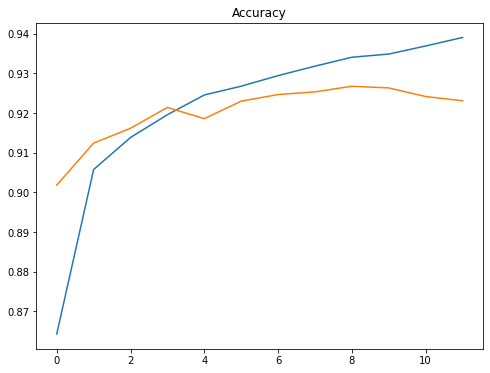

In [ ]:
plot_accuracy_curve(bert_history1)

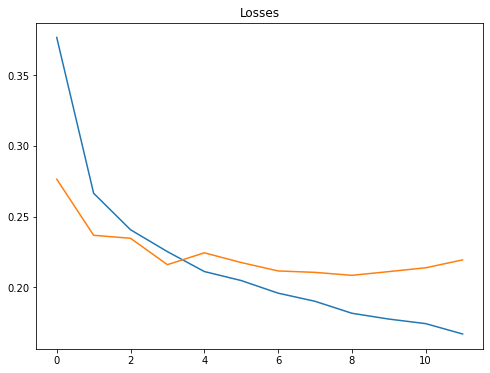

In [ ]:
plot_loss_curve(bert_history1)

We had really slow improvement that's because the learning rate or vanishing gradients problem.

We are saving the weights from the best epoch based on ModelCheckpoint

In [ ]:
bert1.evaluate([test_input_ids1, test_attention_mask1], test_data1.labels.values)

613/613 [==============================] - 31s 50ms/step - loss: 0.2176 - accuracy: 0.9240


[0.21763883531093597, 0.924030601978302]

Using Classification Matrix we are going to see on the test set predicted classes

We see really nice results for the true predictions but we can see little bit more False Positives between Science-Technology and Buisness News, even though it's really hard to tell even with a human prespective. In most cases in Tech news, they are articles with money, investments, GDP and etc. (which is in between)

### Data set 2

In [218]:
bert2 = create_bert(1, activation="sigmoid")

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [219]:
bert2.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.01), 
              metrics=['accuracy'])

In [221]:
bert_history2 = bert2.fit([train_input_ids2, train_attention_mask2], 
                                train_data2.labels.values, batch_size=1024,
                                validation_data=([val_input_ids2, val_attention_mask2], val_data2.labels.values),
                                epochs=15,
                                callbacks=[
                                    EarlyStopping(
                                        monitor='val_accuracy',
                                        patience=3,
                                        restore_best_weights=True),
                                    ModelCheckpoint(
                                        filepath='bert_weights.h5',
                                        monitor='val_loss', 
                                        mode='min', 
                                        save_best_only=True,
                                        save_weights_only=True)
                                   ])

Epoch 1/15
94/94 [==============================] - 163s 2s/step - loss: 0.6116 - accuracy: 0.6690 - val_loss: 0.5270 - val_accuracy: 0.7300
Epoch 2/15
94/94 [==============================] - 147s 2s/step - loss: 0.5347 - accuracy: 0.7318 - val_loss: 0.5087 - val_accuracy: 0.7495
Epoch 3/15
94/94 [==============================] - 147s 2s/step - loss: 0.5206 - accuracy: 0.7422 - val_loss: 0.4987 - val_accuracy: 0.7532
Epoch 4/15
94/94 [==============================] - 147s 2s/step - loss: 0.5141 - accuracy: 0.7468 - val_loss: 0.4989 - val_accuracy: 0.7522
Epoch 5/15
94/94 [==============================] - 147s 2s/step - loss: 0.5056 - accuracy: 0.7513 - val_loss: 0.4935 - val_accuracy: 0.7556
Epoch 6/15
94/94 [==============================] - 147s 2s/step - loss: 0.5015 - accuracy: 0.7562 - val_loss: 0.4881 - val_accuracy: 0.7625
Epoch 7/15
94/94 [==============================] - 147s 2s/step - loss: 0.4974 - accuracy: 0.7569 - val_loss: 0.4904 - val_accuracy: 0.7603
Epoch 8/15
94

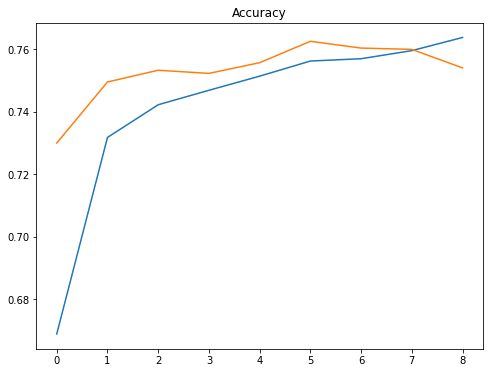

In [228]:
plot_accuracy_curve(bert_history2)

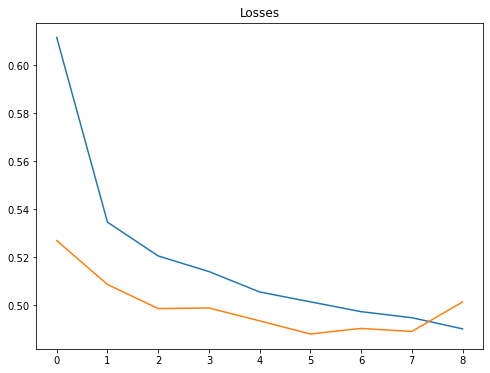

In [227]:
plot_loss_curve(bert_history2)

In [229]:
bert2.evaluate([test_input_ids2, test_attention_mask2], test_data2.labels.values)

376/376 [==============================] - 19s 50ms/step - loss: 0.4950 - accuracy: 0.7548


[0.49495038390159607, 0.7547908425331116]

## C) Model predictions

In [231]:
def plot_cm_bert(cm, labels_dict) :
    plt.figure(figsize=(12,8))
    plt.title("DistilBert Confusion Matrix")
    sns.heatmap(cm,  annot=True, fmt="d")
    plt.xticks(range(len(labels_dict.keys())), labels_dict, fontsize=12)
    plt.yticks(rotation = 45)
    plt.yticks(range(len(labels_dict.keys())), labels_dict, fontsize=12)
    plt.show()

### Data set 1

In [ ]:
preds1 = [np.argmax(i) for i in bert1.predict([test_input_ids1, test_attention_mask1])]
cm1  = confusion_matrix(test_data1.labels.values, preds1)

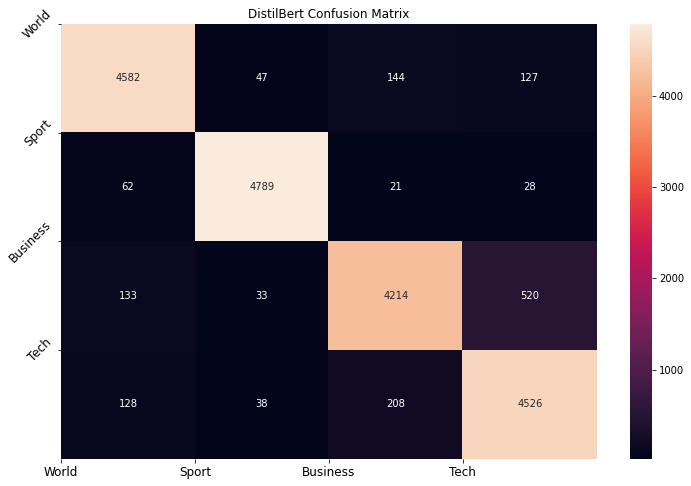

In [ ]:
plot_cm_bert(cm1, labels_dict1)

In [ ]:
GetOnlyScoresNN(bert1, [train_input_ids1, train_attention_mask1], [val_input_ids1, val_attention_mask1],  train_data1.labels, val_data1.labels)

    Accuracy   F1 Score  Precision     Recall  ROC_AUC
0  94.770833  94.766864  94.826836  94.770833        0
   Accuracy   F1 Score  Precision  Recall  ROC_AUC
0    92.675  92.664144  92.717364  92.675        0
Inference time:  149.37818264961243


We can see with that in BERT model the accuracy on the training set is going up but val_accuracy is staying around 92% wich is showing slow overfitting. We got better performence but the training is slow... 

Wold news, Business News and Tech are kinda related. Even human can missclassify them but despite that I am overwhelmed!
The pretrained model of bert is good classifier and works pretty well.
The final state if the given document is certain class is comming from the [CLS] token which we get the values from!

Sport news are most destinguishable also with the world.

### Data set 2

In [235]:
preds2 = [round(i[0]) for i in bert2.predict([test_input_ids2, test_attention_mask2])]
cm2  = confusion_matrix(test_data2.labels.values, preds2)

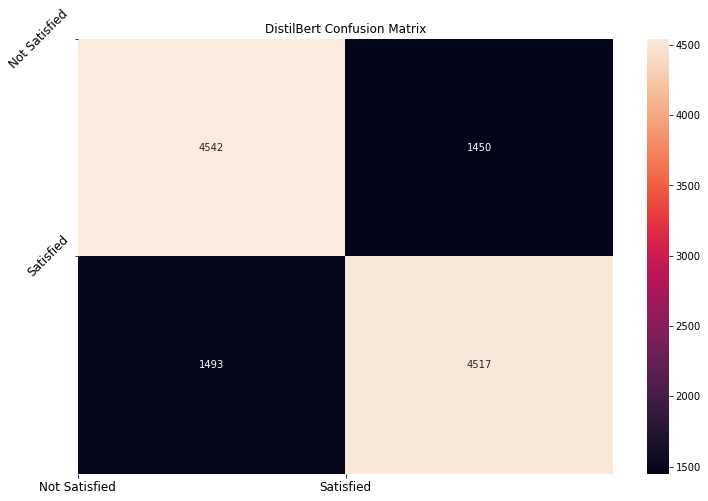

In [236]:
plot_cm_bert(cm2, labels_dict2)

In [ ]:
GetOnlyScoresNN(bert2, [train_input_ids2, train_attention_mask2], [val_input_ids2, val_attention_mask2], train_data2.labels, val_data2.labels)